## EDA: Predicting Concrete Strength

This Python Notebook contains a brief analysis of the dataset for the Concrete Strength competition hosted by Kaggle. For this competition, the dataset is actually a synthetic dataset created from a neural network that was trained on a separate dataset used for predicting the strength of a piece of concrete. 

For this exercise, the train dataset is examined by checking for multicolinearity, the distribution of each continuous variable, the relationships of each feature with the target, and Z Scores are calculated for all of the variables to hopefully detect possible outliers. 


### Quick Glance

First, take a look at a small sample of the data and check for any null values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics, model_selection, preprocessing

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sns.set_style('darkgrid')
sns.set_palette('Spectral')

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
data_input_path = '/kaggle/input/playground-series-s3e9/'
train_df = pd.read_csv(data_input_path + 'train.csv')
test_df = pd.read_csv(data_input_path + 'test.csv')

train_df.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [3]:
cols_w_null_dict = {}

for col in train_df.columns:
    # grab the total number of null values in a column
    train_col_null_count = train_df[col].isnull().sum()
    # if the column
    if train_col_null_count > 0:
        cols_w_null_dict['train_' + str(col)] = train_col_null_count
    if col in test_df.columns:
        test_col_null_count = test_df[col].isnull().sum()
        if test_col_null_count > 0:
            cols_w_null_dict['test_' + str(col)] = test_col_null_count

cols_w_null_dict

{}

### MultiColinearity

Check for multicolinearity uing a heat map and the Pearson Correlation coefficients for all of the features that are continuous variables. 

#### Notes:
* There appears to be a negative relationship between WaterComponent and SuperplasticizerComponent
* SuperplasticizerComponent and FlyAshComponent have a slightly positive correlation

In [4]:
train_df.corr(method='pearson')

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,1.000000,-0.027110,-0.015162,0.045413,-0.009377,0.003155,-0.003475,0.023182,0.010859,0.011853
CementComponent,-0.027110,1.000000,-0.366493,-0.300175,-0.013257,0.031064,0.051756,-0.342021,0.096401,0.158000
BlastFurnaceSlag,-0.015162,-0.366493,1.000000,-0.168852,0.045222,0.110017,-0.282500,-0.172138,-0.055200,0.057506
FlyAshComponent,0.045413,-0.300175,-0.168852,1.000000,-0.356596,0.460729,-0.077742,0.114354,-0.131903,0.031606
WaterComponent,-0.009377,-0.013257,0.045222,-0.356596,1.000000,-0.652649,-0.062145,-0.347965,0.235572,-0.113678
SuperplasticizerComponent,0.003155,0.031064,0.110017,0.460729,-0.652649,1.000000,-0.309127,0.170732,-0.168666,0.208249
CoarseAggregateComponent,-0.003475,0.051756,-0.282500,-0.077742,-0.062145,-0.309127,1.000000,-0.263621,-0.017923,-0.098410
FineAggregateComponent,0.023182,-0.342021,-0.172138,0.114354,-0.347965,0.170732,-0.263621,1.000000,-0.110100,-0.073900
AgeInDays,0.010859,0.096401,-0.055200,-0.131903,0.235572,-0.168666,-0.017923,-0.110100,1.000000,0.334204
Strength,0.011853,0.158000,0.057506,0.031606,-0.113678,0.208249,-0.098410,-0.073900,0.334204,1.000000


<Axes: >

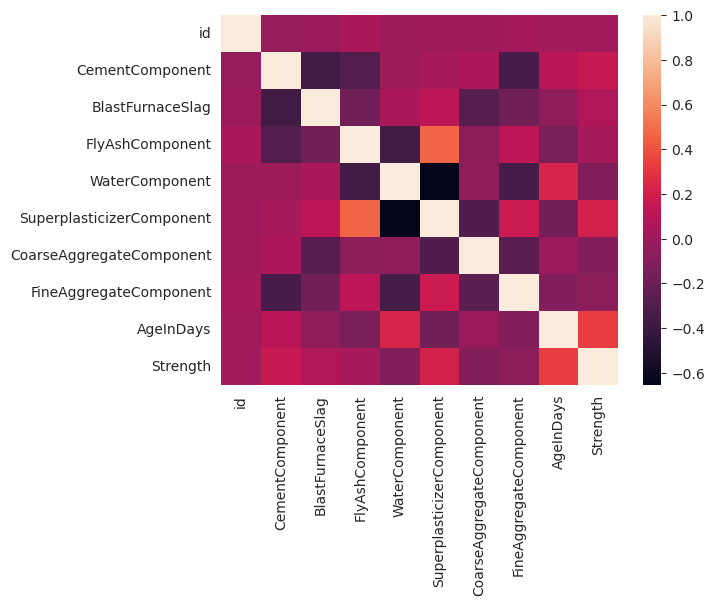

In [5]:
sns.heatmap(train_df.corr(method='pearson'))

### Distributions of Continuous Features

Examine how the various features are distributed. 

#### Notes:
* **CementComponent: somewhat normal, with a weird drop around 450**
* BlastFurnaceSlag: heavily left skewed towards zero
* FlyAshComponent: heavily left skewed towards zero
* **WaterComponent: relatively flat with three spikes around 185, 190-195, and above 220**
* SuperplasticizerComponent: mostly zero appears nonzero values are centered around 10
* **CoarseAggregateComponent: ranges from 800 to 1150, slightly right skewed**
* FineAggregateComponent: mostly normal, centered around 800 with a small spike around 600
* **AgeInDays: doesn't really appear to be truly continuous, most of the values are 25**
* Strength: mostly normal, centered around 35

<Axes: xlabel='Strength', ylabel='Count'>

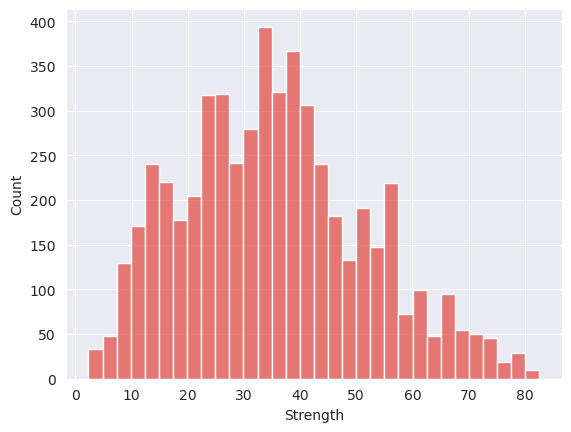

In [12]:
sns.histplot(data = train_df,x = 'Strength')

<Axes: xlabel='AgeInDays', ylabel='Count'>

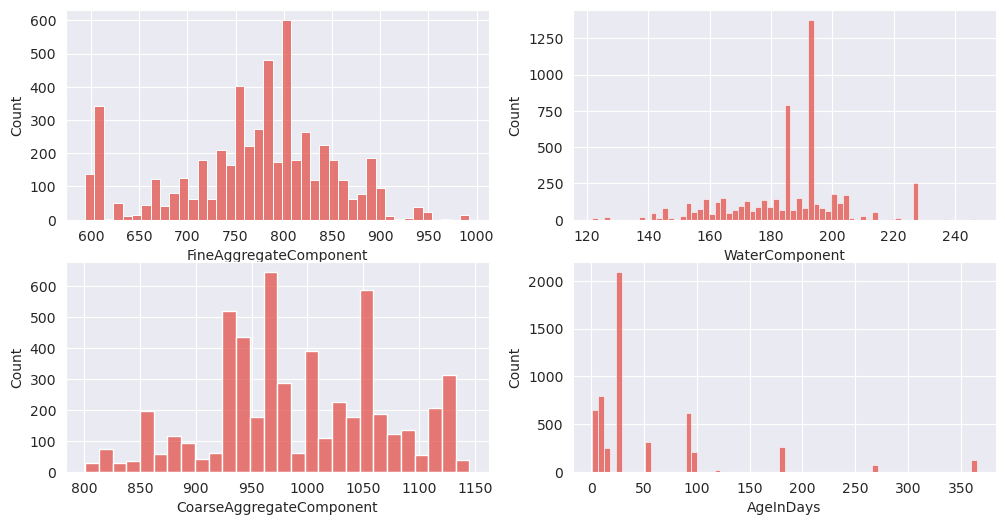

In [6]:
fig, axes = plt.subplots(2,2, figsize = (12,6))

sns.histplot(data = train_df,x = 'FineAggregateComponent', ax = axes[0,0])
sns.histplot(data = train_df,x = 'WaterComponent', ax = axes[0,1])
sns.histplot(data = train_df,x = 'CoarseAggregateComponent', ax = axes[1,0])
sns.histplot(data = train_df,x = 'AgeInDays', ax = axes[1,1])

### Feature Relationships with Strength

Try to visualize and better understand how the various features and the Strength target are related. 

#### Notes:

* CementComponent: Slightly positive with a lot of noise
* BlastFurnaceSlag: Line chart doesn't appear to suggest any relationship with Strength
* FlyAshComponent: Line chart doesn't appear to suggest any relationship with Strength
* WaterComponent: Line chart doesn't appear to suggest any relationship with Strength
* SuperplasticizerComponent: Line chart doesn't appear to suggest any relationship with Strength
* CoarseAggregateComponent: Line chart doesn't appear to suggest any relationship with Strength
* **FineAggregateComponent: No relationship with Strength, but a clear dip around 975**
* **AgeInDays: Somewhat positive, there are Spikes in Strength when AgeInDays is equal to 50 and 100**


<Axes: xlabel='AgeInDays', ylabel='Strength'>

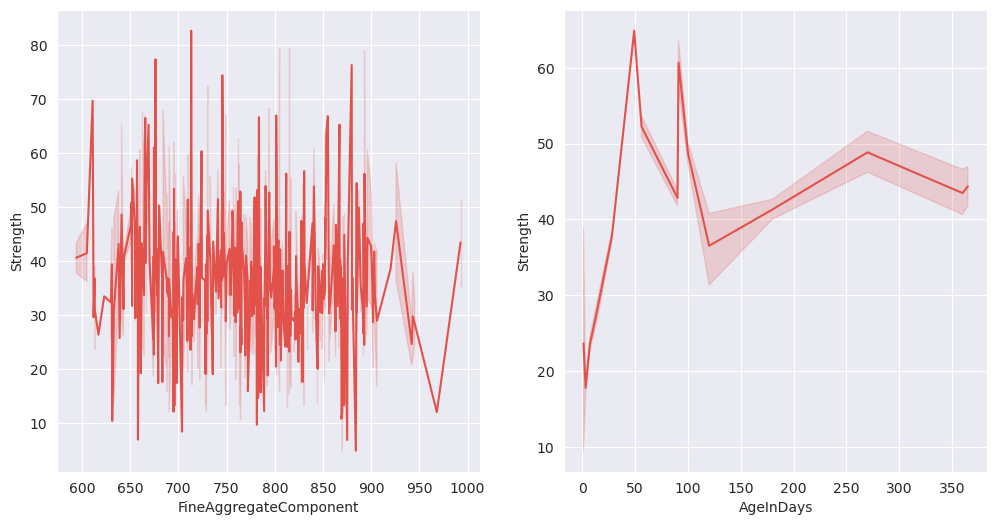

In [7]:
fig, axes = plt.subplots(1,2, figsize = (12,6))

sns.lineplot(data = train_df, x = 'FineAggregateComponent', y = 'Strength', ax=axes[0])
sns.lineplot(data = train_df, x = 'AgeInDays', y = 'Strength', ax=axes[1])

### Outlier Detection

Outliers can significantly impact the performance and assumptions of a regression model. In order to detect any possible outliers, I'll calculate the Z-Scores for all of the observations in each feature then determine the threshold to use. 

Note, the formula to calculate the Z-score for a data point x is:

Z = (x - μ) / σ

In [8]:
# calculate means for each independent, continuous variable
cementcomponent_mean = train_df['CementComponent'].mean()
blastfurnaceslag_mean = train_df['BlastFurnaceSlag'].mean()
flyashcomponent_mean = train_df['FlyAshComponent'].mean()
watercomponent_mean = train_df['WaterComponent'].mean()
superplasticizercomponent_mean = train_df['SuperplasticizerComponent'].mean()
coarseaggregatecomponent_mean = train_df['CoarseAggregateComponent'].mean()
fineaggregatecomponent_mean = train_df['FineAggregateComponent'].mean()
ageindays_mean = train_df['AgeInDays'].mean()
strength_mean = train_df['Strength'].mean()

# calculate standard deviation
cementcomponent_stdev = train_df['CementComponent'].std()
blastfurnaceslag_stdev = train_df['BlastFurnaceSlag'].std()
flyashcomponent_stdev = train_df['FlyAshComponent'].std()
watercomponent_stdev = train_df['WaterComponent'].std()
superplasticizercomponent_stdev = train_df['SuperplasticizerComponent'].std()
coarseaggregatecomponent_stdev = train_df['CoarseAggregateComponent'].std()
fineaggregatecomponent_stdev = train_df['FineAggregateComponent'].std()
ageindays_stdev = train_df['AgeInDays'].std()
strength_stdev = train_df['Strength'].std()

# calculate the z score
train_df['z_cementcomponent'] = (train_df['CementComponent'] - cementcomponent_mean) / cementcomponent_stdev
train_df['z_blastfurnaceslag'] = (train_df['BlastFurnaceSlag'] - blastfurnaceslag_mean) / blastfurnaceslag_stdev
train_df['z_flyashcomponent'] = (train_df['FlyAshComponent'] - flyashcomponent_mean) / flyashcomponent_stdev
train_df['z_watercomponent'] = (train_df['WaterComponent'] - watercomponent_mean) / watercomponent_stdev
train_df['z_superplasticizercomponent'] = (train_df['SuperplasticizerComponent'] - superplasticizercomponent_mean) / superplasticizercomponent_stdev
train_df['z_coarseaggregatecomponent'] = (train_df['CoarseAggregateComponent'] - coarseaggregatecomponent_mean) / coarseaggregatecomponent_stdev
train_df['z_fineaggregatecomponent'] = (train_df['FineAggregateComponent'] - fineaggregatecomponent_mean) / fineaggregatecomponent_stdev
train_df['z_ageindays'] = (train_df['AgeInDays'] - ageindays_mean) / ageindays_stdev
train_df['z_strength'] = (train_df['Strength'] - strength_mean) / strength_stdev

### Distribution of Z Scores

* CementComponent: There doesn't appear to be any extreme outliers
* **BlastFurnaceSlag: The majority of values appear to have a negative Z Score, could the values close to 3 be inflating the mean?**
* **FlyAshComponent: Similar to BlastFurnaceSlag, most values have a negative Z Score**
* WaterComponent: Some observations close to 3
* **SuperplasticizerComponent: Some observations have a Z Score of almost 5**
* CoarseAggregateComponent: There doesn't appear to be any extreme outliers
* FineAggregateComponent: A few observations are close to 3
* **AgeInDays: Note, this feature is distributed in an odd way, there are a few records at 3 and 4**
* Strength: A small amount of values are close to 3

<Axes: xlabel='z_ageindays', ylabel='Count'>

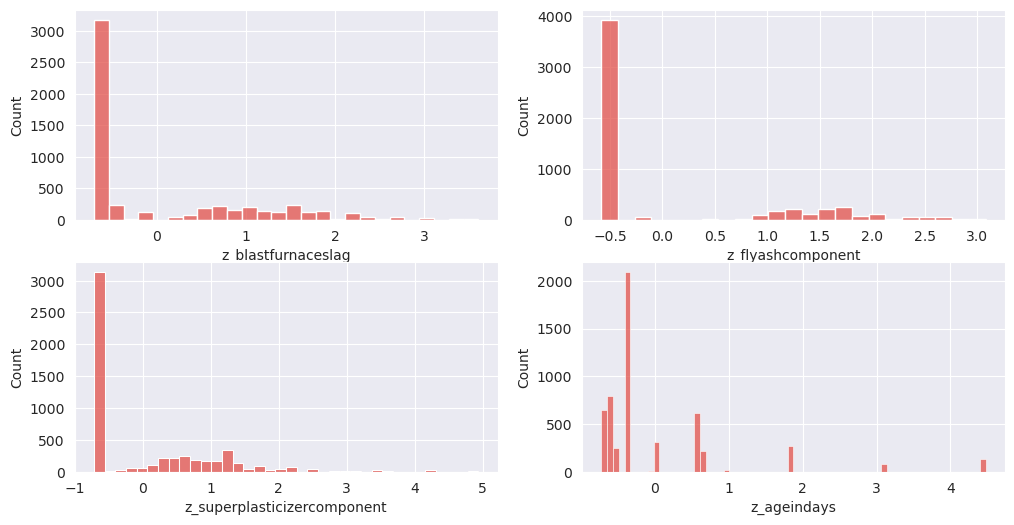

In [9]:
snfig, axes = plt.subplots(2,2, figsize = (12,6))

sns.histplot(data = train_df,x = 'z_blastfurnaceslag', ax = axes[0,0])
sns.histplot(data = train_df,x = 'z_flyashcomponent', ax = axes[0,1])
sns.histplot(data = train_df,x = 'z_superplasticizercomponent', ax = axes[1,0])
sns.histplot(data = train_df,x = 'z_ageindays', ax = axes[1,1])

### Notable Findings

* Strength appears to be distributed with a slight, left skew with a center around 35
* Most of the Age-In-Days values are equal to 25
* There are peaks in Strength when the Age-In-Days variable equals 50 or 100
* The Super Plasticizer and the Age-In-Days fields contain values with Z Scores as high as 4-5
* A vast of majority of the Blast Furnace Slag and Fly Ash Component Z-Scores are negative